# Intent Classifier : camembert -base


Date: Nov 8, 2024

# Libraries

In [1]:
# #https://model-training-wenwen1.notebook.us-east-1.sagemaker.aws/lab
# !pip install torch
# !pip install sentencepiece
# !pip install transformers
# # !pip install openpyxl
# # !pip install scikit-learn
# !pip install seaborn

In [50]:
from transformers import CamembertModel, CamembertTokenizer
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
from transformers import CamembertModel, CamembertTokenizer
from sklearn.preprocessing import LabelEncoder
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)
print("Number of GPUs:", torch.cuda.device_count())

PyTorch version: 2.4.1+cu121
CUDA available: True
CUDA version: 12.1
Number of GPUs: 1


In [51]:
df = pd.read_excel("../regular_train_V3/data/final_train_set_sme_labelled.xlsx")
df = df.rename(columns = {"Query":"User Prompt", "DataScientist Label": "label"})

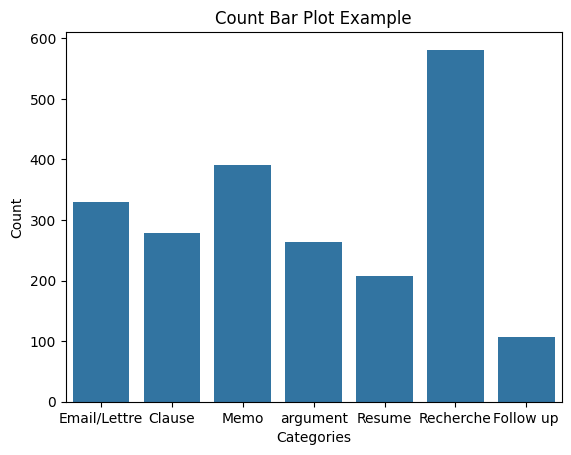

In [52]:

df = df[["User Prompt" , "label"]]
df['label'] = df['label'].str.strip()
df = df[(df["label"] != "Incomplete") & (df["label"] != "Independant")]
df = df.dropna()
df.label.value_counts()

sns.countplot(x='label', data=df)
plt.title('Count Bar Plot Example')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.show()

In [53]:
df.head(3)

,User Prompt,label
0,Mon client agent comptable d'un lycée fait l'o...,Email/Lettre
1,"Dans un courriel, informe les autres juristes ...",Email/Lettre
2,Rédige un mail en expliquant à mon client le s...,Email/Lettre


In [54]:
df_combined= df
df_combined = df_combined.drop_duplicates()
df_combined.shape

(2159, 2)

In [55]:
df_combined.label.value_counts()

label
Recherche       581
Memo            391
Email/Lettre    330
Clause          279
argument        264
Resume          208
Follow up       106
Name: count, dtype: int64

In [56]:
# df_combined['User Prompt'] = df_combined['User Prompt'].str.lower()
# import re
# keyword_check = [
#     "mémo", "mémorandum", "mémento", "vade-mecum", "note", "aide-mémoire", "pense-bête",
#     "synthèse", "topo", "exposé", "étude", "explication", "énumération", "description",
#     "expliquez le contexte", "énumérer les étapes", "mémo juridique", "memo", "memorandum",
#     "reminder", "note", "aide-memoire", "summary", "synthesis",
#     "exposition", "study", "explanation", "enumeration", "description", "sommaire"
# ]

# # Escape keywords to handle special characters in regex
# escaped_keywords = [re.escape(keyword) for keyword in keyword_check]

# # Create regex pattern with word boundaries
# pattern = r'\b(' + '|'.join(escaped_keywords) + r')\b'

# # Filter rows containing the keywords
# filtered_rows = df_combined[df_combined['User Prompt'].str.contains(pattern, case=False, na=False, regex=True)]
# filtered_rows.shape
# filtered_rows.to_excel("./data/filtered_rows_memo.xlsx")

In [57]:

X_train, X_temp, y_train, y_temp = train_test_split(df_combined["User Prompt"], df_combined["label"], test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

#create test set
test_df = pd.DataFrame({'X_test': X_test, 'y_test': y_test})
#test_df.to_excel('./training_data/test_data.xlsx', index=False)

train_texts = X_train.tolist()
val_texts = X_val.tolist()


model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)
camembert = CamembertModel.from_pretrained(model_name)

train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

train_labels = y_train.tolist()
val_labels = y_val.tolist()
label_dict = {"Recherche": 0,"Resume": 1,"Email/Lettre": 2,"Memo": 3,"Clause": 4,"argument": 5, "Follow up":6}
train_labels = [label_dict[label] for label in train_labels]
val_labels = [label_dict[label] for label in val_labels]


X_train shape: (1727,)
y_train shape: (1727,)
X_val shape: (216,)
y_val shape: (216,)
X_test shape: (216,)
y_test shape: (216,)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [58]:
train_dataset = TensorDataset(
    torch.tensor(train_encodings["input_ids"]),
    torch.tensor(train_encodings["attention_mask"]),
    torch.tensor(train_labels),
)

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = TensorDataset(
    torch.tensor(val_encodings["input_ids"]),
    torch.tensor(val_encodings["attention_mask"]),
    torch.tensor(val_labels),
)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

In [59]:
class CamembertClassifier(nn.Module):
    def __init__(self, camembert_model_name='camembert-base', num_labels=2):
        super(CamembertClassifier, self).__init__()
        self.camembert = CamembertModel.from_pretrained(camembert_model_name)
        self.linear1 = nn.Linear(self.camembert.config.hidden_size, 512)
        self.linear2 = nn.Linear(512, num_labels)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask=None):
        outputs = self.camembert(input_ids=input_ids, attention_mask=attention_mask)
        cls_output = outputs[0][:, 0, :]  # Use the output of the [CLS] token
        x = self.dropout(cls_output)
        x = self.linear1(x)
        x = self.relu(x)
        logits = self.linear2(x)
        return logits



In [60]:
import torch.optim as optim
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup, CamembertTokenizer, AdamW
from tqdm import tqdm
import os

# Initialize tokenizer
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Hyperparameters
num_epochs = 40
learning_rate = 5e-5
batch_size = 16
warmup_steps = 20

# Initialize model
model = CamembertClassifier(num_labels=7)

# # Freeze the first n layers of the Camembert model
# for name, param in model.camembert.named_parameters():
#     print(name)
#     if "embeddings" in name:
#         param.requires_grad = False
#         print("Freeze")
        
#     elif "pooler" in name:
#         print("Unfreeze")
    
#     elif int(name.split('.')[2]) < 6:
#         param.requires_grad = False
#         print("Freeze")
#     else:
#          print("Unfreeze")

# Unfreeze all layers
# for name, param in model.camembert.named_parameters():
#     param.requires_grad = True
# #     print(f"{name} - Unfreeze")
        


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [61]:
# check trianbale params in model

for name, param in model.camembert.named_parameters():
    if param.requires_grad == True:
        print(name)
        
for name, param in model.named_parameters():
    if param.requires_grad == True:
        print(name)

embeddings.word_embeddings.weight
embeddings.position_embeddings.weight
embeddings.token_type_embeddings.weight
embeddings.LayerNorm.weight
embeddings.LayerNorm.bias
encoder.layer.0.attention.self.query.weight
encoder.layer.0.attention.self.query.bias
encoder.layer.0.attention.self.key.weight
encoder.layer.0.attention.self.key.bias
encoder.layer.0.attention.self.value.weight
encoder.layer.0.attention.self.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.attention.output.LayerNorm.weight
encoder.layer.0.attention.output.LayerNorm.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.output.LayerNorm.weight
encoder.layer.0.output.LayerNorm.bias
encoder.layer.1.attention.self.query.weight
encoder.layer.1.attention.self.query.bias
encoder.layer.1.attention.self.key.weight
encoder.layer.1.attention.self.key

In [62]:

# #Extract labels from train and validation datasets
# train_labels = [label for _,_, label in train_dataset]
# val_labels = [label for _,_, label in val_dataset]

In [64]:
# Move model to the appropriate device (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define the optimizer (example with weight decay)
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if p.requires_grad], 'weight_decay': 0.01}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

#Extract labels from train and validation datasets
train_labels = [label for _,_, label in train_dataset]
val_labels = [label for _,_, label in val_dataset]

# Calculate label weights to balance sampling probabilities
train_class_counts = np.bincount(train_labels)
train_class_weights = 1.0 / train_class_counts
train_sample_weights = [train_class_weights[label] for label in train_labels]

val_class_counts = np.bincount(val_labels)
val_class_weights = 1.0 / val_class_counts
val_sample_weights = [val_class_weights[label] for label in val_labels]

# Create samplers with weights
train_sampler = WeightedRandomSampler(train_sample_weights, len(train_sample_weights))
val_sampler = WeightedRandomSampler(val_sample_weights, len(val_sample_weights))

# Create dataloaders with weighted samplers
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, sampler=val_sampler, batch_size=batch_size)

# # Create dataloaders for train and validation sets
# train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
# val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Learning rate scheduler
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Initialize variables to track the best model with early stopping
best_val_loss = float('inf')
best_val_acc = 0
best_model_path = './best_camembert_classifier/full_trained/'
early_stopping_patience = 6
no_improvement_epochs = 0

# Training loop
for epoch in range(num_epochs):
    print()
    model.train()
    epoch_train_loss = 0
    correct_train_preds = 0
    total_train_preds = 0
    
    for batch in tqdm(train_dataloader, desc="Training Epoch", leave=True):
        # Move batch to device
        input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
        
        # Zero gradients, perform forward pass, compute loss, and backpropagate
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        # Calculate training accuracy
        preds = torch.argmax(outputs, dim=-1)
        correct_train_preds += (preds == labels).sum().item()
        total_train_preds += labels.size(0)
        
        # Track the training loss
        epoch_train_loss += loss.item()

    # Calculate average training loss and accuracy
    avg_train_loss = epoch_train_loss / len(train_dataloader.dataset)
    train_accuracy = correct_train_preds / total_train_preds
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    
    # Validation loop
    model.eval()
    epoch_val_loss = 0
    correct_val_preds = 0
    total_val_preds = 0
    
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Validation Epoch", leave=True):
            # Move batch to device
            input_ids, attention_mask, labels = tuple(t.to(device) for t in batch)
            
            # Forward pass for validation
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            
            # Calculate validation accuracy
            preds = torch.argmax(outputs, dim=-1)
            correct_val_preds += (preds == labels).sum().item()
            total_val_preds += labels.size(0)
            
            # Track the validation loss
            epoch_val_loss += loss.item()

    # Calculate average validation loss and accuracy
    avg_val_loss = epoch_val_loss / len(val_dataloader.dataset)
    val_accuracy = correct_val_preds / total_val_preds
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_val_acc = val_accuracy
        no_improvement_epochs = 0
        os.makedirs(best_model_path, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(best_model_path, "pytorch_model.pth"))
        tokenizer.save_pretrained(best_model_path)
        print(f"Best model saved to {best_model_path} based on validation loss")

    elif val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        no_improvement_epochs = 0
        os.makedirs(best_model_path, exist_ok=True)
        torch.save(model.state_dict(), os.path.join(best_model_path, "pytorch_model.pth"))
        tokenizer.save_pretrained(best_model_path)
        print(f"Best model saved to {best_model_path} based on validation accuracy")

    else:
        no_improvement_epochs += 1
        print(f"No improvement for {no_improvement_epochs} epochs")

    # Early stopping condition
    if no_improvement_epochs >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

print("Training complete. Best model saved based on validation loss or accuracy.")

Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 1/40, Training Loss: 0.0030, Training Accuracy: 0.9913


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.68it/s]


Epoch 1/40, Validation Loss: 0.0236, Validation Accuracy: 0.9167
Best model saved to ./best_camembert_classifier/full_trained/ based on validation loss



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.40it/s]


Epoch 2/40, Training Loss: 0.0030, Training Accuracy: 0.9890


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.88it/s]


Epoch 2/40, Validation Loss: 0.0238, Validation Accuracy: 0.9259
Best model saved to ./best_camembert_classifier/full_trained/ based on validation accuracy



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 3/40, Training Loss: 0.0044, Training Accuracy: 0.9844


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.73it/s]


Epoch 3/40, Validation Loss: 0.0343, Validation Accuracy: 0.9213
No improvement for 1 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 4/40, Training Loss: 0.0026, Training Accuracy: 0.9902


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.76it/s]


Epoch 4/40, Validation Loss: 0.0390, Validation Accuracy: 0.8935
No improvement for 2 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 5/40, Training Loss: 0.0017, Training Accuracy: 0.9925


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.74it/s]


Epoch 5/40, Validation Loss: 0.0305, Validation Accuracy: 0.8981
No improvement for 3 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


Epoch 6/40, Training Loss: 0.0023, Training Accuracy: 0.9925


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.74it/s]


Epoch 6/40, Validation Loss: 0.0305, Validation Accuracy: 0.9028
No improvement for 4 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


Epoch 7/40, Training Loss: 0.0175, Training Accuracy: 0.9160


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.70it/s]


Epoch 7/40, Validation Loss: 0.0252, Validation Accuracy: 0.9352
Best model saved to ./best_camembert_classifier/full_trained/ based on validation accuracy



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


Epoch 8/40, Training Loss: 0.0063, Training Accuracy: 0.9693


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.61it/s]


Epoch 8/40, Validation Loss: 0.0263, Validation Accuracy: 0.9352
No improvement for 1 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


Epoch 9/40, Training Loss: 0.0033, Training Accuracy: 0.9849


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.69it/s]


Epoch 9/40, Validation Loss: 0.0324, Validation Accuracy: 0.9074
No improvement for 2 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.38it/s]


Epoch 10/40, Training Loss: 0.0023, Training Accuracy: 0.9890


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.69it/s]


Epoch 10/40, Validation Loss: 0.0321, Validation Accuracy: 0.9074
No improvement for 3 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 11/40, Training Loss: 0.0023, Training Accuracy: 0.9867


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.68it/s]


Epoch 11/40, Validation Loss: 0.0370, Validation Accuracy: 0.9028
No improvement for 4 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 12/40, Training Loss: 0.0025, Training Accuracy: 0.9902


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.73it/s]


Epoch 12/40, Validation Loss: 0.0268, Validation Accuracy: 0.9306
No improvement for 5 epochs



Training Epoch: 100%|██████████| 108/108 [00:14<00:00,  7.39it/s]


Epoch 13/40, Training Loss: 0.0020, Training Accuracy: 0.9890


Validation Epoch: 100%|██████████| 14/14 [00:00<00:00, 38.69it/s]

Epoch 13/40, Validation Loss: 0.0308, Validation Accuracy: 0.9213
No improvement for 6 epochs
Early stopping at epoch 13
Training complete. Best model saved based on validation loss or accuracy.


## Testing on validation set

In [65]:
#Loading the best model
from transformers import AutoTokenizer

fine_tuned_model = CamembertClassifier(num_labels=7)
tokenizer = CamembertTokenizer.from_pretrained('camembert-base')

# Load the state_dict for the model
fine_tuned_model.load_state_dict(torch.load(os.path.join(best_model_path, "pytorch_model.pth")))

# Load the tokenizer
# tokenizer = AutoTokenizer.from_pretrained(best_model_path)

# Set the model to evaluation mode
fine_tuned_model.eval()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/tmp/ipykernel_31885/4215055508.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to 

CamembertClassifier(
  (camembert): CamembertModel(
    (embeddings): CamembertEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): CamembertEncoder(
      (layer): ModuleList(
        (0-11): 12 x CamembertLayer(
          (attention): CamembertAttention(
            (self): CamembertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): CamembertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
          

In [66]:
label_dict = {"Recherche": 0,"Resume": 1,"Email/Lettre": 2,"Memo": 3,"Clause": 4,"argument": 5, "Follow up":6}
class_names = ["Recherche", "Resume", "Email/Lettre", "Memo", "Clause", "argument", "Follow up"]

test_texts = test_df["X_test"].tolist()
test_labels = test_df["y_test"].tolist()
numeric_labels = [label_dict[label] for label in test_labels]

print(test_df.head(5))
print(test_df["y_test"].value_counts())

                                                 X_test        y_test
1459  Peut-on appliquer la complicité aux infraction...     Recherche
233   Rédige une lettre de transmission d'un mémoire...  Email/Lettre
1618  Est-ce que je peux demander un dédommagement? ...     Recherche
1189  CAA Nancy, 3e ch., arrêt, 13 avr. 2021, n° 20N...        Resume
1121  Demandez un résumé de TA Strasbourg, 22 décemb...        Resume
y_test
Recherche       60
Memo            36
Clause          35
Email/Lettre    30
argument        24
Resume          21
Follow up       10
Name: count, dtype: int64


In [67]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(numeric_labels),
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Make predictions on the test set
queries = []
true_labels = []
predicted_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, batch_labels = tuple(t.to(device) for t in batch)
        logits = model(input_ids, attention_mask)
        _, preds = torch.max(logits, dim=1)
        queries += tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        true_labels += batch_labels.cpu().numpy().tolist()

        predicted_labels += preds.cpu().numpy().tolist()

In [69]:
true_labels= [class_names[label] for label in true_labels]
predicted_labels = [class_names[label] for label in predicted_labels]

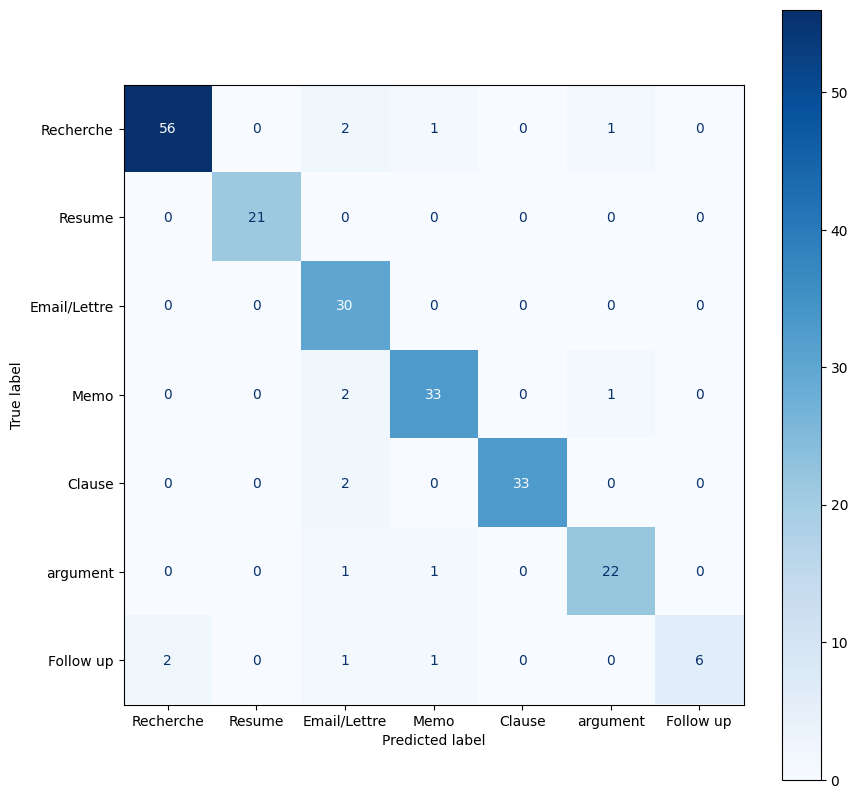

In [70]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation="horizontal")
plt.show()

In [71]:
from sklearn.metrics import classification_report

class_names = ["Recherche", "Resume", "Email/Lettre", "Memo", "Clause", "argument", "Follow up"]
report = classification_report(true_labels, predicted_labels, labels=class_names)

print(report)

              precision    recall  f1-score   support

   Recherche       0.97      0.93      0.95        60
      Resume       1.00      1.00      1.00        21
Email/Lettre       0.79      1.00      0.88        30
        Memo       0.92      0.92      0.92        36
      Clause       1.00      0.94      0.97        35
    argument       0.92      0.92      0.92        24
   Follow up       1.00      0.60      0.75        10

    accuracy                           0.93       216
   macro avg       0.94      0.90      0.91       216
weighted avg       0.94      0.93      0.93       216



## Testing data with not exposed set

In [72]:
test_set = pd.read_excel("data/all_intent_model_test_set_final.xlsx")
test_set = test_set[["Query","Label"]].rename(columns={"Query": "X_test", "Label": "y_test"})[["X_test", "y_test"]]

In [73]:
# test_set = pd.read_excel("../data/my_test_utf8.xlsx").rename(columns={"query": "X_test", "intent-groundtruth": "y_test"})[["X_test", "y_test"]]
# print(test_set.head(5))

print(test_set["y_test"].value_counts())

test_texts = test_set["X_test"].tolist()
test_labels = test_set["y_test"].tolist()
numeric_labels = [label_dict[label] for label in test_labels]


y_test
Recherche       77
Memo            43
Email/Lettre    41
Clause          23
argument        23
Resume          22
Follow up       15
Name: count, dtype: int64


In [74]:
test_encodings = tokenizer(test_texts, truncation=True, padding=True)
test_dataset = TensorDataset(
    torch.tensor(test_encodings["input_ids"]),
    torch.tensor(test_encodings["attention_mask"]),
    torch.tensor(numeric_labels),
)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Make predictions on the test set
queries = []
true_labels = []
predicted_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, batch_labels = tuple(t.to(device) for t in batch)
        logits = model(input_ids, attention_mask)
        _, preds = torch.max(logits, dim=1)
        queries += tokenizer.batch_decode(input_ids, skip_special_tokens=True)
        true_labels += batch_labels.cpu().numpy().tolist()

        predicted_labels += preds.cpu().numpy().tolist()

In [76]:
# predicted_labels
# true_labels

In [77]:
true_labels = [label for label in test_labels]

reversed_dict = {v: k for k, v in label_dict.items()}
predicted_labels = [reversed_dict[label_num] for label_num in predicted_labels]

# Create a data frame with the queries, true labels, and predicted labels
data = {"query": queries, "label": true_labels, "prediction": predicted_labels}
df_pred = pd.DataFrame(data)

df_pred.head()


,query,label,prediction
0,Rédige moi une clause de non-sollicitation de ...,Clause,Clause
1,Je veux une clause de nomination de mandataire...,Clause,Clause
2,Je veux une clause d'administration prolongée ...,Clause,Clause
3,Rédige-moi une clause de limitation territoria...,Clause,Clause
4,Donne moi une clause de volonté pour dispositi...,Clause,Clause


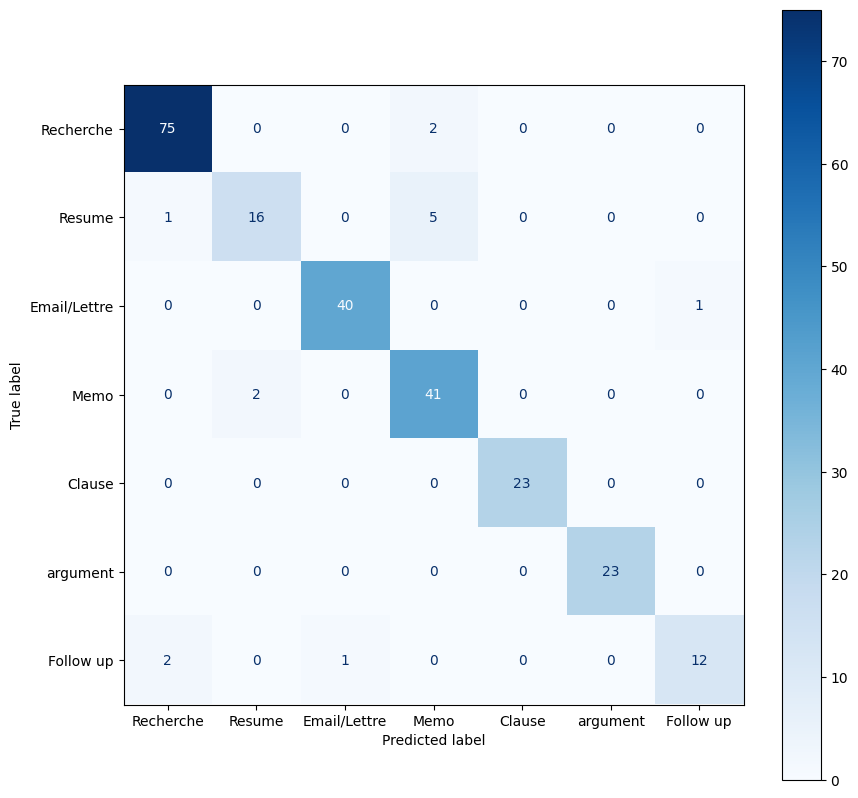

In [78]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(include_values=True, cmap="Blues", ax=ax, xticks_rotation="horizontal")
plt.show()

In [79]:
from sklearn.metrics import classification_report

class_names = ["Recherche", "Resume", "Email/Lettre", "Memo", "Clause", "argument", "Follow up"]
report = classification_report(true_labels, predicted_labels, labels=class_names)

print(report)

              precision    recall  f1-score   support

   Recherche       0.96      0.97      0.97        77
      Resume       0.89      0.73      0.80        22
Email/Lettre       0.98      0.98      0.98        41
        Memo       0.85      0.95      0.90        43
      Clause       1.00      1.00      1.00        23
    argument       1.00      1.00      1.00        23
   Follow up       0.92      0.80      0.86        15

    accuracy                           0.94       244
   macro avg       0.94      0.92      0.93       244
weighted avg       0.94      0.94      0.94       244



In [80]:
data = {"query": queries, "label": true_labels, "prediction": predicted_labels}
df_pred = pd.DataFrame(data)

df_pred.to_excel("data/best_camembert_classifier_output.xlsx")

In [83]:

# # Define the French queries
queries = [
    "Rédigez-moi un mémo concernant un vol", 
    "Rédigez-moi un courriel concernant un vol",
    "Peux-tu rédiger un argument  au client pour lui expliquer la procédure pour vendre les biens et que ces derniers doivent être conformes à la réglementation et au zonage ",
    "Qu'est-ce que le report d'imposition ?",
    "Qu'avez-vous modifié pour rendre la lettre plus agressive ?",
    "Qu'avez-vous modifié pour rendre la lettre plus agressive dans le ton ?",
    "Que dire sous la juridiction de Hawaï ?",
    "Merci, veuillez réessayer avec toutes les cours fédérales.",
    "Synthétisez cela davantage.",
    "Simplifiez le langage dans cette note.",
    "Simplifiez davantage le langage.",
    "Réécrivez cela avec un accent sur la clarté.",
    "Réécrivez cela pour être plus lisible.",
    "Réécrivez cela de manière plus formelle.",
    "Réécrivez cela pour être plus engageant.",
    "Réécrivez cela de manière moins technique.",
    "Réécrivez cela de manière moins formelle.",
    "Réécrivez cela de manière moins agressive.",
    "Réécrivez cela dans un ton plus positif.",
    "Révisez cela pour le rendre plus empathique.",
    "Révisez cela pour le rendre plus succinct et engageant.",
    "Révisez cela pour le rendre plus succinct et clair.",
    "Révisez cela pour le rendre plus positif dans le ton.",
    "Révisez cela pour le rendre plus engageant et informatif.",
    "Révisez cela pour le rendre plus concis et précis.",
    "Révisez cela pour le rendre plus concis et informatif.",
    "Révisez cela pour le rendre plus concis et convaincant.",
    "Réorganisez cette réponse pour en maximiser la cohérence, le flux et la séquence logique.",
    "Retirez le langage subjectif ou émotionnel de cette réponse.",
    "Affinez et distillez cela davantage.",
    "Reformulez cette ébauche dans un ton plus affirmé.",
    "Veuillez adoucir le ton de cette réponse.",
    "Veuillez simplifier cette clause.",
    "Veuillez simplifier le langage législatif.",
    "Veuillez simplifier les termes juridiques complexes.",
    "Veuillez examiner l'ébauche de l'Accord Structuré d'Achat pour en vérifier la complétude et suggérer des ajouts utiles.",
    "Veuillez fournir plus de détails sur les points clés.",
    "Veuillez rendre cette section plus concise.",
    "Veuillez rendre cette section plus concise et claire.",
    "Veuillez rendre cette réponse plus concise et informative.",
    "Veuillez rendre cette réponse plus assertive.",
    "Veuillez rendre cela plus direct.",
    "Veuillez rendre cela plus concis.",
    "Veuillez rendre cette lettre plus agressive.",
    "Veuillez rendre cela moins contraignant.",
    "Veuillez rendre cette ébauche plus agressive.",
    "Veuillez rendre ce contrat plus complet.",
    "Veuillez rendre le langage plus inclusif.",
    "Veuillez rendre l'argumentation moins technique et plus accessible.",
    "Veuillez le rendre plus amical.",
    "Veuillez améliorer le raisonnement juridique.",
    "Veuillez rédiger une lettre plus ferme.",
    "Veuillez créer une version plus ferme de cette lettre.",
    "Veuillez clarifier le jargon juridique.",
    "Veuillez ajouter plus d'exemples pour étayer l'argument.",
    "Veuillez ajouter plus de détails à l'argumentation.",
    "Veuillez ajouter plus de clarté à l'explication.",
    "Non. Ce que vous devez faire, c'est rédiger un résumé pour que le tribunal l'examine, pas un autre ordre.",
    "Rendre ce texte plus long.",
    "Rendre ce résumé plus détaillé.",
    "Rendre ce résumé plus concis.",
    "Rendre ce résumé moins contraignant et antagoniste.",
    "Rendre cette réponse plus détaillée et complète.",
    "Rendre cette réponse plus concise et directe.",
    "Rendre cette réponse plus assertive.",
    "Rendre cette ébauche plus conviviale et claire.",
    "Rendre cette ébauche plus concise et claire.",
    "Rendre cette ébauche plus convaincante.",
    "Rendre ce contrat plus spécifique.",
    "Rendre ce contrat plus complet.",
    "Rendre cette clause plus détaillée.",
    "Rendre cet argument plus concis et pertinent.",
    "Rendre cela un bail plus formel avec un titre et un préambule d'introduction. Ajouter des considérants. Ajouter des blocs de signature."
    "Rédiger un argument juridique pour une audience de voir-dire selon lequel le témoignage d’un témoin ayant entendu l’accusé admettre un crime peut être utilisé en vertu de l’exception du ouï-dire"
]

# # Preprocess the queries (tokenize)
# inputs = tokenizer(queries, padding=True, truncation=True, return_tensors="pt")

# # Make sure the model is in evaluation mode
# fine_tuned_model.eval()

# # Perform prediction
# with torch.no_grad():
#     outputs = fine_tuned_model(**inputs)

#     predicted_labels = torch.argmax(outputs, dim=-1)
#     print(predicted_labels)
   
#     label_dict = {"Recherche": 0,"Resume": 1,"Email/Lettre": 2,"Memo": 3,"Clause": 4,"argument": 5, "Follow up":6}
#     class_names = ["Recherche", "Resume", "Email/Lettre", "Memo", "Clause", "argument", "Follow up"]
#     predictions = [class_names[label.item()] for label in predicted_labels]

# # Output the results
# for query, prediction in zip(queries, predictions):
#     #print(f"Query: '{query}' -> Predicted Label: {prediction}")
#     print(f"Predicted Label: {prediction}")
